In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from nltk.metrics.agreement import AnnotationTask
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import accuracy_score as accuracy
from scipy.stats import spearmanr as spearman
pilot_file = "Batch_3198536_batch_results.csv"

In [2]:
data = pd.read_csv(pilot_file)
data.columns = [c.replace('.', '_') for c in data.columns]
#data.head()

In [3]:
def extract_dataframe(data):
    '''
    Input: Pandas csv dataframe obtained from MTurk
    
    Output: Pandas dataframe levelled by (User x Sentenced_ID)
    '''
    data["dicts"] = data["Input_var_arrays"].map(lambda x: json.loads(x))
    global_list = []
    
    for row in data.itertuples():
        for idx, local_dict in enumerate(row.dicts):
            temp_dict = local_dict.copy()
            var_instant = "Answer_instantaneous" + str(idx+1)
            var_instant_c =  "Answer_confidence_instantaneous" + str(idx+1)
            var_start = "Answer_startpt" + str(idx+1)
            var_start_c = "Answer_confidence_startpoint" + str(idx+1)
            var_end = "Answer_endpt" + str(idx+1)
            var_end_c = "Answer_confidence_endpoint" + str(idx+1)
            var_duration = "Answer_duration" + str(idx+1)
            var_duration_c = "Answer_confidence_duration" + str(idx+1)

            temp_dict["is_instant"] = getattr(row, var_instant)
            temp_dict["conf_instant"] = getattr(row, var_instant_c)
            temp_dict["has_start"] = getattr(row, var_start)
            temp_dict["conf_start"] = getattr(row, var_start_c)
            temp_dict["has_end"] = getattr(row, var_end)
            temp_dict["conf_end"] = getattr(row, var_end_c)
            temp_dict["duration"] = getattr(row, var_duration)
            temp_dict["conf_duration"] = getattr(row, var_duration_c)
            temp_dict["worker_id"] = row.WorkerId
            temp_dict["hit_id"] = row.HITId

            global_list.append(temp_dict)
            
    return pd.DataFrame(global_list)


In [4]:
pilot_data = extract_dataframe(data)

#Re-arrange the order 
cols = list(pilot_data.columns)
pilot_data = pilot_data[pilot_data.columns[::-1]].drop('sentence', axis=1)

#pilot_data.replace('na',np.NaN, inplace=True)
pilot_data.head
pilot_data['sent_token'] = pilot_data['sentence_id'] + "_" +\
                            pilot_data['pred_token'].map(lambda x: str(x))
pilot_data.to_csv("pilot_data.csv", index=False)

In [5]:
pilot_data.head()

,worker_id,sentence_id,pred_token,pred,is_instant,id,hit_id,has_start,has_end,duration,conf_start,conf_instant,conf_end,conf_duration,sent_token
0,AQ2U4H38MELRY,en-ud-train.conllu 5784,3,occurred,True,1,3NCN4N1H1GM453MD5NG1QQJZWHXBN7,na,na,na,na,2,na,na,en-ud-train.conllu 5784_3
1,AQ2U4H38MELRY,en-ud-train.conllu 5784,5,processing,False,2,3NCN4N1H1GM453MD5NG1QQJZWHXBN7,true,false,7,3,2,2,2,en-ud-train.conllu 5784_5
2,AQ2U4H38MELRY,en-ud-train.conllu 1010,3,held,False,3,3NCN4N1H1GM453MD5NG1QQJZWHXBN7,false,false,5,1,3,2,0,en-ud-train.conllu 1010_3
3,AQ2U4H38MELRY,en-ud-train.conllu 1010,15,curating,False,4,3NCN4N1H1GM453MD5NG1QQJZWHXBN7,false,false,5,2,4,2,1,en-ud-train.conllu 1010_15
4,AQ2U4H38MELRY,en-ud-train.conllu 5106,20,acted,False,5,3NCN4N1H1GM453MD5NG1QQJZWHXBN7,false,false,5,3,2,3,0,en-ud-train.conllu 5106_20


#### Run Mixed Effects Model in R

On the data saved above, run mler models in R to determine values for is_instant, has_start, has_end for each sentence_predicate pair

## Response distribution

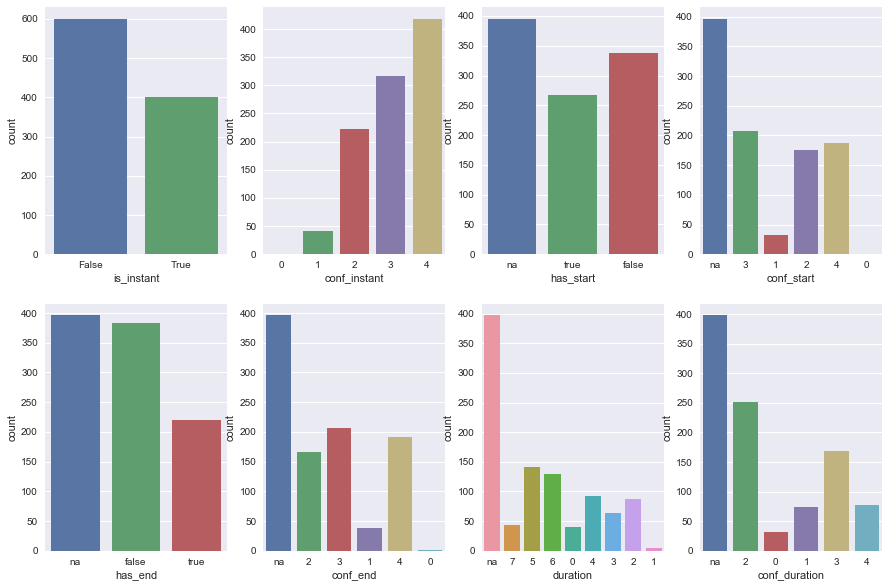

In [6]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 10))

sns.countplot(x='is_instant', data=pilot_data, ax=axs[0][0])
sns.countplot(x='conf_instant', data=pilot_data, ax=axs[0][1])
sns.countplot(x='has_start', data=pilot_data, ax=axs[0][2])
sns.countplot(x='conf_start', data=pilot_data, ax=axs[0][3])
sns.countplot(x='has_end', data=pilot_data, ax=axs[1][0])
sns.countplot(x='conf_end', data=pilot_data, ax=axs[1][1])
sns.countplot(x='duration', data=pilot_data, ax=axs[1][2])
sns.countplot(x='conf_duration', data=pilot_data, ax=axs[1][3])


plt.show()

## Inter-Annotator Agreement

In [7]:
pilot_data['modified_instant'] =  np.where((pilot_data['is_instant'] == True) | 
                                           ((pilot_data['has_start'] == 'true') & 
                                            (pilot_data['has_end'] == 'true') ) 
                                           , True, False)

In [8]:
pilot_data['modified_instant2'] =  np.where( (pilot_data['is_instant'] == True)  | 
                                             ((pilot_data['has_start'] == 'true') & 
                                                (pilot_data['has_end'] == 'true') &
                                                   ((pilot_data['duration'] == '6')|
                                                    (pilot_data['duration'] == '7'))) 
                                           , True, False)

In [9]:
pilot_data['modified_instant3'] =  np.where( (pilot_data['is_instant'] == True)  | 
                                             ((pilot_data['has_start'] == 'true') & 
                                                (pilot_data['has_end'] == 'true') &
                                                    (pilot_data['duration'] == '7'))
                                           , True, False)

In [10]:
pilot_data['modified_instant4'] =  np.where((pilot_data['is_instant'] == True) | 
                                            (pilot_data['duration'] == '6') |
                                            (pilot_data['duration'] == '7')
                                           , True, False)

In [11]:
pilot_data['modified_instant5'] =  np.where((pilot_data['is_instant'] == True) | 
                                            (pilot_data['duration'] == '7')
                                           , True, False)

In [12]:
pilot_data.head()

,worker_id,sentence_id,pred_token,pred,is_instant,id,hit_id,has_start,has_end,duration,conf_start,conf_instant,conf_end,conf_duration,sent_token,modified_instant,modified_instant2,modified_instant3,modified_instant4,modified_instant5
0,AQ2U4H38MELRY,en-ud-train.conllu 5784,3,occurred,True,1,3NCN4N1H1GM453MD5NG1QQJZWHXBN7,na,na,na,na,2,na,na,en-ud-train.conllu 5784_3,True,True,True,True,True
1,AQ2U4H38MELRY,en-ud-train.conllu 5784,5,processing,False,2,3NCN4N1H1GM453MD5NG1QQJZWHXBN7,true,false,7,3,2,2,2,en-ud-train.conllu 5784_5,False,False,False,True,True
2,AQ2U4H38MELRY,en-ud-train.conllu 1010,3,held,False,3,3NCN4N1H1GM453MD5NG1QQJZWHXBN7,false,false,5,1,3,2,0,en-ud-train.conllu 1010_3,False,False,False,False,False
3,AQ2U4H38MELRY,en-ud-train.conllu 1010,15,curating,False,4,3NCN4N1H1GM453MD5NG1QQJZWHXBN7,false,false,5,2,4,2,1,en-ud-train.conllu 1010_15,False,False,False,False,False
4,AQ2U4H38MELRY,en-ud-train.conllu 5106,20,acted,False,5,3NCN4N1H1GM453MD5NG1QQJZWHXBN7,false,false,5,3,2,3,0,en-ud-train.conllu 5106_20,False,False,False,False,False


### Raw Agreement

 #### 1. Stringent (Exact matches for a particular sent-predicate pair)

In [13]:
def calc_raw_agreement(data, key_var, check_var):
    '''
    Input: 
    1. data: Pandas dataframe
    2. key_var: variable based on which raw agreement is to be calculated
    3. check_var: vaiable on which raw agreement is calculated
    
    '''
    print("####### Raw Count for {} ###########".format(check_var))
    ids = set(list(data[key_var].values))

    total_count = len(ids)
    raw_count = 0
    keys = []
    
    for iden in ids:
        temp = list(data[data[key_var] == iden][check_var].values)
        if temp.count(temp[0]) == len(temp):
            raw_count += 1
            keys.append(iden)
     
    agreement = (raw_count/total_count)*100
    
    print("Total count of unique {} is {}".format(key_var, total_count))
    print("Raw count of matched for {} is {}".format(check_var, raw_count))
    print("Inter-annotator agreement for {} is {}%".format(check_var, agreement))
    print("\n")
    
    return agreement, keys

instant_agreement, key_inst = calc_raw_agreement(pilot_data, 'sent_token', 'is_instant')
instant_agreement2, key_inst = calc_raw_agreement(pilot_data, 'sent_token', 'modified_instant3')
start_agreement, key_start = calc_raw_agreement(pilot_data, 'sent_token', 'has_start')
end_agreement, key_end = calc_raw_agreement(pilot_data, 'sent_token', 'has_end')

####### Raw Count for is_instant ###########
Total count of unique sent_token is 200
Raw count of matched for is_instant is 46
Inter-annotator agreement for is_instant is 23.0%


####### Raw Count for modified_instant3 ###########
Total count of unique sent_token is 200
Raw count of matched for modified_instant3 is 47
Inter-annotator agreement for modified_instant3 is 23.5%


####### Raw Count for has_start ###########
Total count of unique sent_token is 200
Raw count of matched for has_start is 17
Inter-annotator agreement for has_start is 8.5%


####### Raw Count for has_end ###########
Total count of unique sent_token is 200
Raw count of matched for has_end is 21
Inter-annotator agreement for has_end is 10.5%




#### 2. Average of scores (Kappa and accuracy) for each pair of annotators 

In [14]:
def extract_pairs_of_workers(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def average_metric_nltk(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score or any other metric 
    
    Output: average kappa score, alpha score for (pairs of annotators) in the dataset.

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    kappas = []
    alphas = []
    
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        
        if common_set == set():
            continue
            
        temp_data = []
        
        for key in common_set:
            val3 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val4 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values 
            temp_data.append((w1,key, val3[0]))
            temp_data.append((w2,key, val4[0]))

        task = AnnotationTask(data=temp_data)
        kappas.append(task.kappa())
        alphas.append(task.alpha())

    return kappas, alphas

def average_metric_sklearn(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score or any other metric 
    
    Output: average kappa score, accuracy and spearman correlation for (pairs of annotators) in the dataset.

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    kappas = []
    accuracies = []
    
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        
        if common_set == set():
            continue
            
        temp1 = []
        temp2 = []
        
        for key in common_set:
            val3 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val4 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values 
            temp1.append(val3[0])
            temp2.append(val4[0])

        if temp1 == [] or temp2 == []:
            continue 
        
        elif temp1==temp2:
            kappas.append(1.0)
        else:
            kappas.append(kappa(temp1, temp2))
        accuracies.append(accuracy(temp1, temp2))
                
    return kappas, accuracies  

def average_kappa_accuracy(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score or any other metric 
    
    Output: average kappa score, accuracy and spearman correlation for (pairs of annotators) in the dataset.

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    kappas = []
    accuracies = []
    
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        
        if common_set == set():
            continue
            
        temp1 = []
        temp2 = []
        if check_var != 'is_instant':
            for key in common_set:
                val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)]['is_instant'].values
                val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)]['is_instant'].values
                #Only compute metrics if both annotators mark not-instantaneous
                if val1[0] == False and val2[0]== False:
                    val3 = data[(data[key_var] == key) & 
                            (data[worker_id] == w1)][check_var].values
                    val4 = data[(data[key_var] == key) & 
                            (data[worker_id] == w2)][check_var].values 
                    temp1.append(val3[0])
                    temp2.append(val4[0])     
                else:
                    continue     
        else: #check_var == 'is_instant'
            for key in common_set:
                val3 = data[(data[key_var] == key) & 
                            (data[worker_id] == w1)][check_var].values
                val4 = data[(data[key_var] == key) & 
                            (data[worker_id] == w2)][check_var].values 
                temp1.append(val3[0])
                temp2.append(val4[0])
                   
        if temp1 == [] or temp2 == []:
            continue
            
        elif temp1==temp2:
            kappas.append(1.0)
        else:
            kappas.append(kappa(temp1, temp2))
        accuracies.append(accuracy(temp1, temp2))
        
    return kappas, accuracies  

def average_correlation(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score or any other metric 
    
    Output: average spearman correlation for (pairs of annotators) in the dataset.

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    corrs = []
    
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        
        if common_set == set():
            continue
            
        temp1 = []
        temp2 = []

        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                    (data[worker_id] == w1)]['is_instant'].values
            val2 = data[(data[key_var] == key) & 
                    (data[worker_id] == w2)]['is_instant'].values
            #Only compute metrics if both annotators mark not-instantaneous
            if val1[0] == False and val2[0]== False:
                val3 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
                val4 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values 
                temp1.append(val3[0])
                temp2.append(val4[0])     
                
        if temp1 == [] or temp2 == []:
            continue
        elif temp1.count(temp1[0]) == len(temp1) or temp2.count(temp2[0]) == len(temp2):
            print(temp1)
            print(temp2)
            break
        elif temp1==temp2:
            corrs.append(1.0)
        else:
            corrs.append(spearman(temp1, temp2))
        
    return corrs

In [15]:
kappas = {}
alphas = {}
vars_temp = ['is_instant', 'modified_instant', 'modified_instant3']
for var in vars_temp:
    kappas[var], alphas[var] = average_metric_nltk(pilot_data, 'worker_id', 'sent_token', var)
    print("{} -- Completed!".format(var))


is_instant -- Completed!
modified_instant -- Completed!
modified_instant3 -- Completed!


In [16]:
# corrs = {}
# vars1 = ['is_instant', 'has_start', 'has_end', 
#              'modified_instant',  'modified_instant2', 'modified_instant3', 'modified_instant4']
# vars2 = ['duration','conf_instant', 'conf_start', 'conf_end', 'conf_duration']
# for var in vars2:
#     corrs[var] = average_correlation(pilot_data, 'worker_id', 'sent_pred', var)
#     print("{} -- Completed!".format(var))
    

In [17]:
kappa_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in kappas.items() ]))
alpha_data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in alphas.items() ]))

In [18]:
kappa_data.head()

,is_instant,modified_instant,modified_instant3
0,0.40000,0.200000,0.40000
1,0.40000,0.200000,0.40000
2,0.20000,0.000000,0.20000
3,0.60000,0.000000,0.40000
4,0.52381,0.347826,0.52381


In [19]:
print('Average Kappa for "is_instant" variable: {}'.format(np.mean(kappa_data['is_instant'])))
print('Average Kappa for "modified_instant" variable: {}'.format(np.mean(kappa_data['modified_instant'])))
#print('Average Kappa for "modified_instant2" variable: {}'.format(np.mean(kappa_data['modified_instant2'])))
print('Average Kappa for "modified_instant3" variable: {}'.format(np.mean(kappa_data['modified_instant3'])))
#print('Average Kappa for "modified_instant4" variable: {}'.format(np.mean(kappa_data['modified_instant4'])))
#print('Average Kappa for "modified_instant5" variable: {}'.format(np.mean(kappa_data['modified_instant5'])))
print("\n")
#print('Average accuracy for "is_instant" variable: {}'.format(np.mean(acc_data['is_instant'])))
#print('Average accuracy for "has_start" variable: {}'.format(np.mean(acc_data['has_start'])))
#print('Average accuracy for "has_end" variable: {}'.format(np.mean(acc_data['has_end'])))

Average Kappa for "is_instant" variable: 0.21641387999717634
Average Kappa for "modified_instant" variable: 0.15856996730147901
Average Kappa for "modified_instant3" variable: 0.22593986614729208




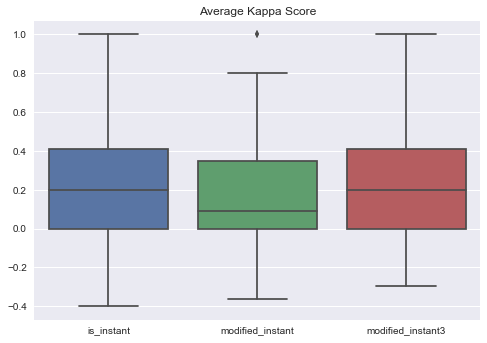

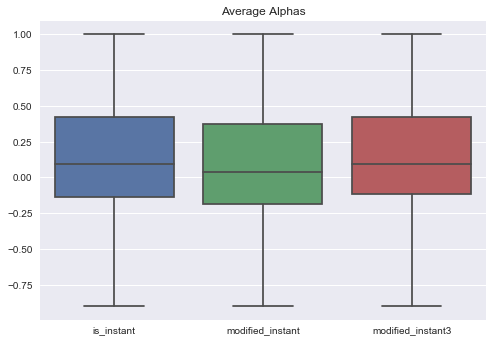

In [20]:
ax = sns.boxplot(data=kappa_data)
ax.set(title="Average Kappa Score")
plt.show()

ax = sns.boxplot(data=alpha_data)
ax.set(title="Average Alphas")
plt.show()

# ax = sns.boxplot(data=corrs_data)
# ax.set(title="Average Spearman Correlation")
# plt.show()

In [21]:
pilot_data['weight_duration'] = pilot_data.groupby('worker_id').duration.apply(lambda x: x.rank()/len(x))